In [48]:
import pandas as pd
import openpyxl
#pip install gensim
import gensim
import gensim.corpora as corpora
import nltk
import spacy
import matplotlib.pyplot as plt
from sklearn.decomposition import LatentDirichletAllocation
from nltk.corpus import stopwords
from nltk.stem.snowball import GermanStemmer
from sklearn.preprocessing import LabelEncoder
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from sklearn.ensemble import  RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import LeaveOneOut, GridSearchCV, cross_val_predict
from sklearn.model_selection import cross_val_score, StratifiedKFold
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sentence_transformers import SentenceTransformer
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline

## Pre processing

In [50]:
df = pd.read_excel("20250602_Anfragen_Sample.xlsx")
df_clean = clean_text(df, "Kundenanfrage")
df_clean["Kundenanfrage"] = df_clean["Kundenanfrage"].apply(remove_stopwords_from_series)
df_clean["tokens"] = df_clean["Kundenanfrage"].str.split()
id2word = corpora.Dictionary(df_clean["tokens"])
texts = df_clean["tokens"]
corpus = [id2word.doc2bow(text) for text in texts]

In [49]:
nltk.download('stopwords')
stopwords_l = stopwords.words("german")

def tokenize(text):
    nltk.download('stopwords')
    stopwords_l = stopwords.words("german")
    tokens = gensim.utils.simple_preprocess(text, deacc=True)
    tokens = [token for token in tokens if token not in stopwords_l]
    return tokens



def clean_text(df: pd.DataFrame, x : str):

    df[x] = df[x].str.lower()
    df[x] = df[x].replace(r"^(.*?),","",regex= True)
    # df[x] = df[x].replace(r"(viele|mit|herzliche|liebe|beste|freundliche).*grüß.*", "", regex=True) # zu breit, fuehrt teilw zu fehlern
    df[x] = df[x].replace(
    r"(mit\s+(freundlichen?|besten?)\s+grüß\w*|"
    r"freundlich\w*\s+grüß\w*|"
    r"herzlich\w*\s+grüß\w*|"
    r"lieb\w*\s+grüß\w*|"
    r"beste\s+grüß\w*)\s*.*$",
    "",
    regex=True)
    df[x] = df[x].replace(r" bitte*", "", regex=True)
    df[x] = df[x].replace(r"vielen dank.*","",regex = True)
    df[x] = df[x].replace(r'[^\s\w]+','',regex = True)

    return df


def remove_stopwords_from_series(text):
    words = text.split()
    words_filtered = [w for w in words if w not in stopwords_l]
    return " ".join(words_filtered)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam

# --- Feature-Extraktion ---
vectorizer = TfidfVectorizer(
    max_features=10000,
    ngram_range=(1, 2),
    min_df=2,
    max_df=0.9
)
X = vectorizer.fit_transform(df_clean["Kundenanfrage"]).toarray()

# --- Zielvariable vorbereiten ---
le = LabelEncoder()
y = le.fit_transform(df_clean["Unterkategorie2"])
y_cat = to_categorical(y)  # one-hot encoding für Keras

# --- Train/Test-Split ---
X_train, X_test, y_train, y_test = train_test_split(X, y_cat, test_size=0.2, random_state=42)

# --- Modell definieren ---
model = Sequential()
model.add(Dense(512, activation='relu', input_shape=(X.shape[1],)))
model.add(Dropout(0.5))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(y_cat.shape[1], activation='softmax'))  # Multi-Klassen-Ausgabe

# --- Kompilieren ---
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# --- Trainieren ---
history = model.fit(
    X_train, y_train,
    epochs=15,
    batch_size=32,
    validation_split=0.1,
    verbose=1
)

# --- Evaluieren ---
loss, acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {acc:.4f}")

Epoch 1/15


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 92ms/step - accuracy: 0.1232 - loss: 2.4810 - val_accuracy: 0.1000 - val_loss: 2.4882
Epoch 2/15
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.2538 - loss: 2.4342 - val_accuracy: 0.1500 - val_loss: 2.4771
Epoch 3/15
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.2445 - loss: 2.3699 - val_accuracy: 0.1500 - val_loss: 2.4548
Epoch 4/15
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.3246 - loss: 2.2988 - val_accuracy: 0.1500 - val_loss: 2.4233
Epoch 5/15
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.3895 - loss: 2.1326 - val_accuracy: 0.1500 - val_loss: 2.3727
Epoch 6/15
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.4703 - loss: 1.9063 - val_accuracy: 0.2000 - val_loss: 2.2183
Epoch 7/15
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.6431 - loss: 1.6163 - val_accuracy: 0.4500 - val_loss: 1.9461
Epoch 8/15
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.8627 - loss: 1.2302 - val_accuracy: 0.6000 - val_loss: 1.7060
Epoch 9/15


In [ ]:
stemmer = GermanStemmer()

df_clean["stemmed"] = df["Kundenanfrage"].apply(lambda tokens: [stemmer.stem(token) for token in tokens])

,stemmed
0,"[h, e, u, t, e, , m, o, r, g, e, n, , v, e, ..."
1,"[s, e, i, t, , g, e, s, t, e, r, n, , r, e, ..."
2,"[b, e, i, m, , l, o, g, i, n, , o, n, l, i, ..."
3,"[k, u, r, z, e, m, , s, m, a, r, t, p, h, o, ..."
4,"[l, e, i, d, e, r, , f, u, n, k, t, i, o, n, ..."
...,...
244,"[n, a, m, e, , p, a, u, l, , f, i, s, c, h, ..."
245,"[f, r, u, h, e, r, e, r, , n, a, m, e, , l, ..."
246,"[b, i, s, h, e, r, i, g, e, r, , n, a, m, e, ..."
247,"[b, i, s, l, a, n, g, , p, a, u, l, , s, c, ..."


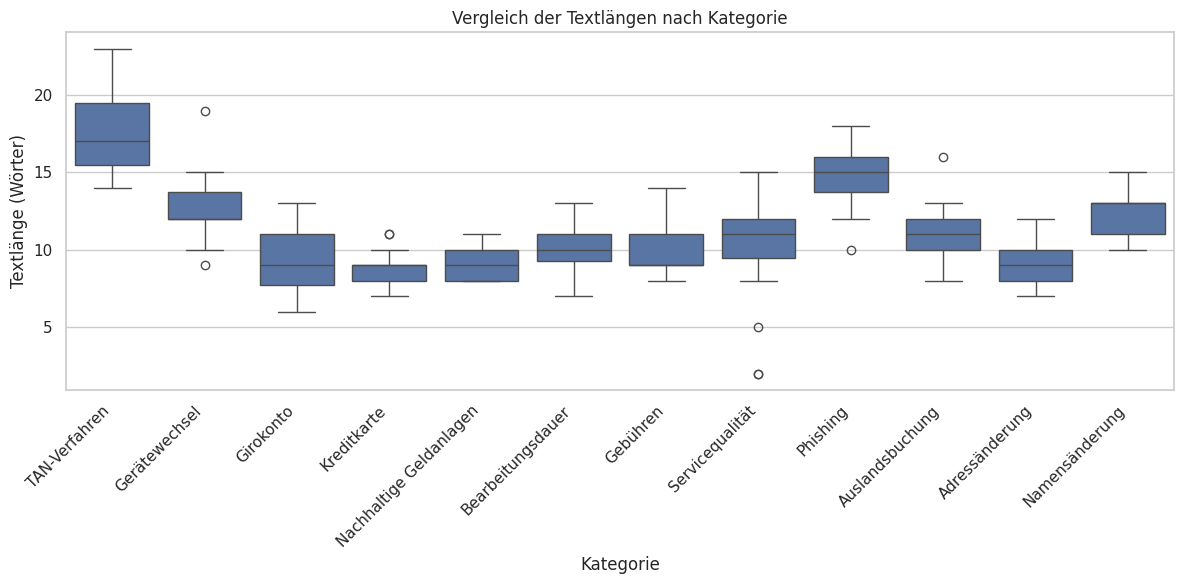

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Textlänge berechnen (Anzahl Wörter oder Zeichen)
df_clean["text_length"] = df_clean["Kundenanfrage"].apply(lambda x: len(str(x).split()))

# Plot-Stil (optional)
sns.set(style="whitegrid")

# Boxplot zeichnen
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_clean, x="Unterkategorie2", y="text_length")
plt.xticks(rotation=45, ha='right')
plt.xlabel("Kategorie")
plt.ylabel("Textlänge (Wörter)")
plt.title("Vergleich der Textlängen nach Kategorie")
plt.tight_layout()
plt.show()

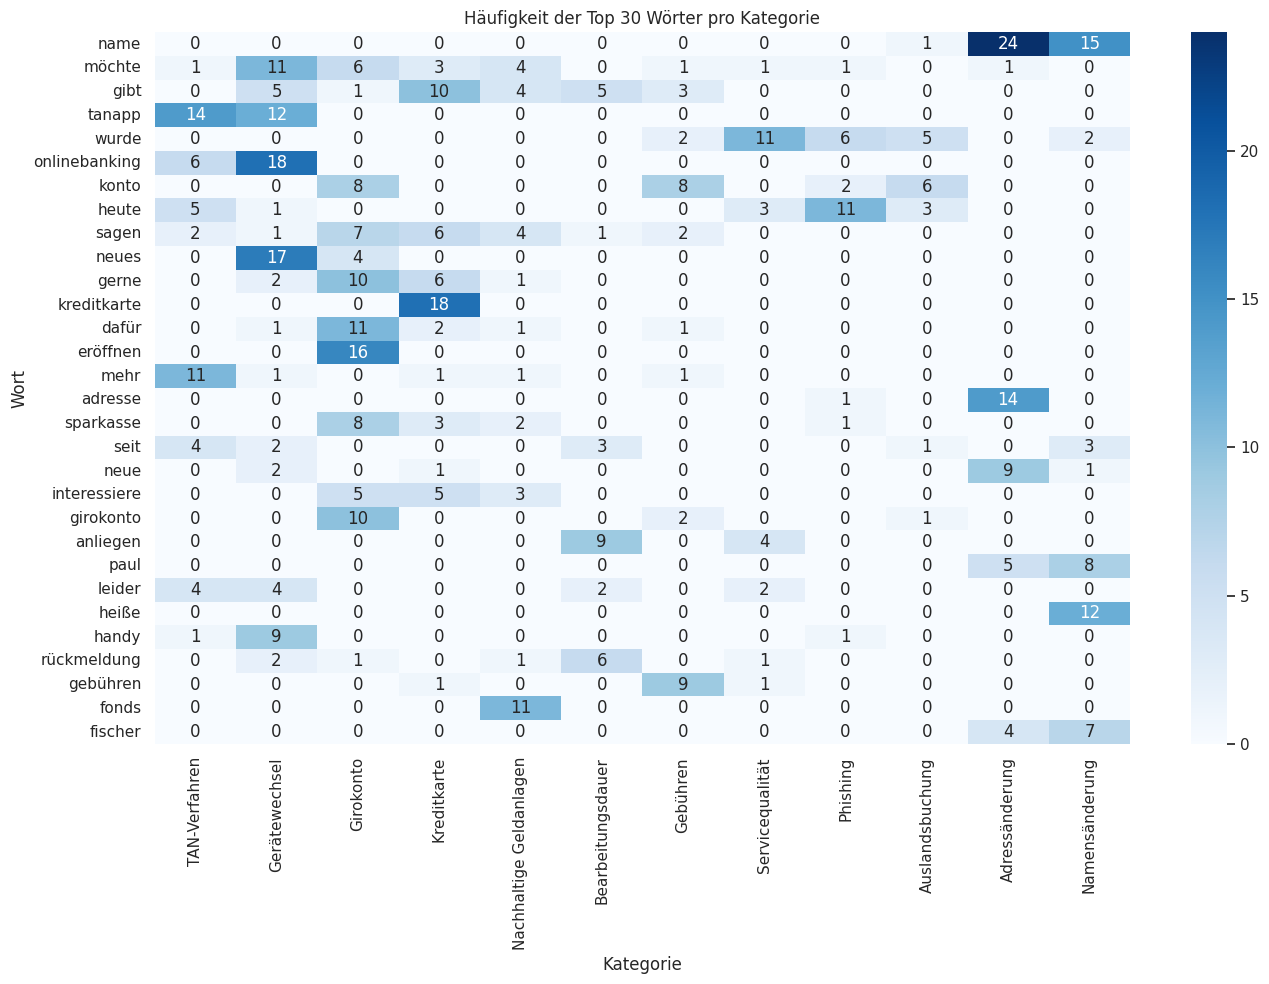

In [ ]:
from collections import Counter, defaultdict
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Alle Tokens zählen
all_tokens = df_clean["tokens"].explode()
word_counts = Counter(all_tokens)

# 2. Top 30 häufigste Wörter
top_30_words = [word for word, _ in word_counts.most_common(30)]

# 3. Kategorie-Wortzählung vorbereiten
categories = df_clean["Unterkategorie2"].unique()
heatmap_data = pd.DataFrame(0, index=top_30_words, columns=categories)

# 4. Fülle die Matrix: Zähle Wortvorkommen je Kategorie
for _, row in df_clean.iterrows():
    tokens = row["tokens"]
    category = row["Unterkategorie2"]
    for token in tokens:
        if token in top_30_words:
            heatmap_data.at[token, category] += 1

# 5. Heatmap zeichnen
plt.figure(figsize=(14, 10))
sns.heatmap(heatmap_data, annot=True, fmt='d', cmap='Blues')
plt.title("Häufigkeit der Top 30 Wörter pro Kategorie")
plt.xlabel("Kategorie")
plt.ylabel("Wort")
plt.tight_layout()
plt.show()

In [ ]:
df_group = pd.DataFrame(df_clean.groupby("Unterkategorie2")["Kundenanfrage"].agg(lambda x: " ".join(x)))

Adressänderung


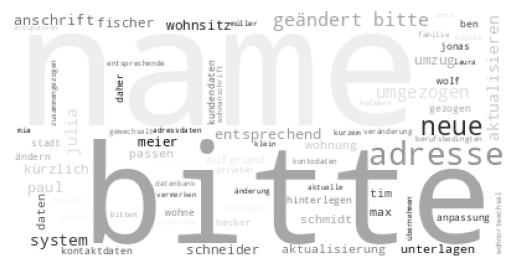

Auslandsbuchung


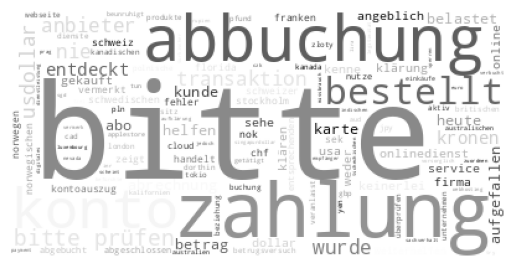

Bearbeitungsdauer


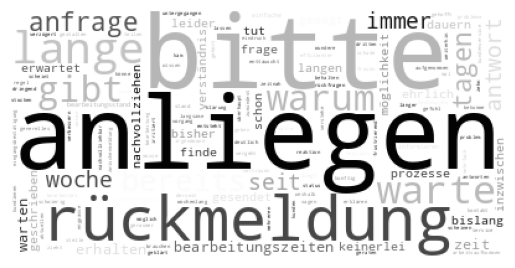

Gebühren


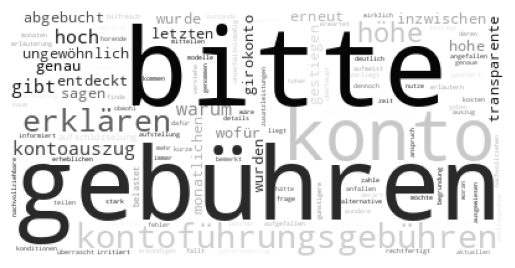

Gerätewechsel


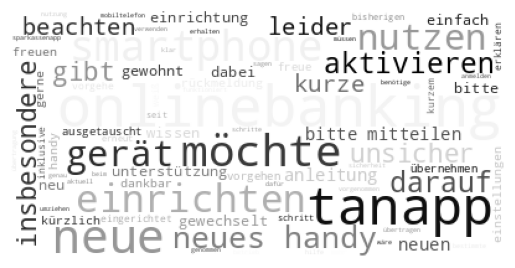

Girokonto


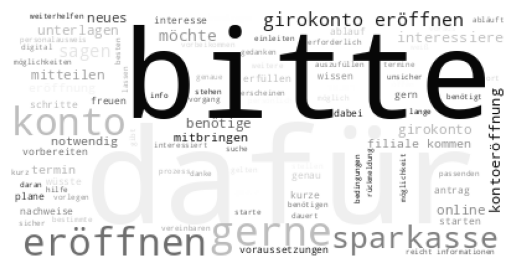

Kreditkarte


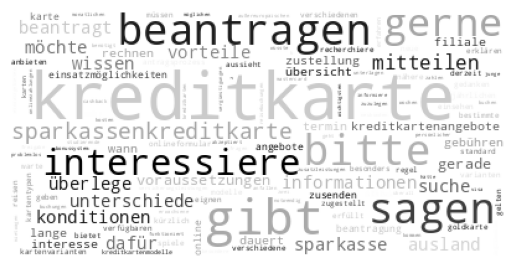

Nachhaltige Geldanlagen


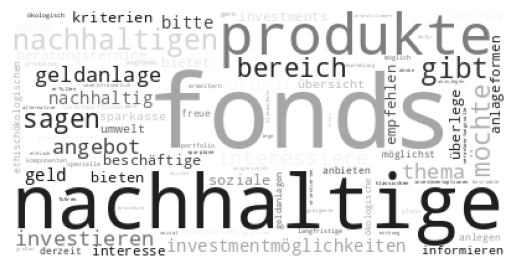

Namensänderung


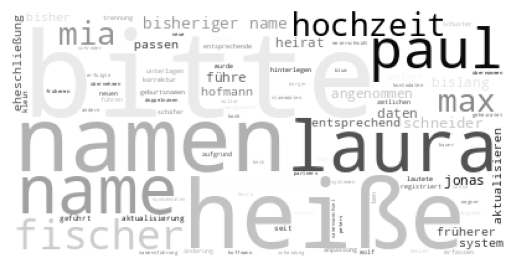

Phishing


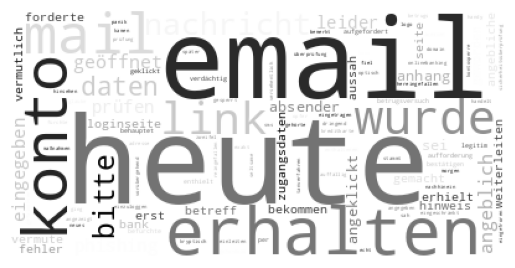

Servicequalität


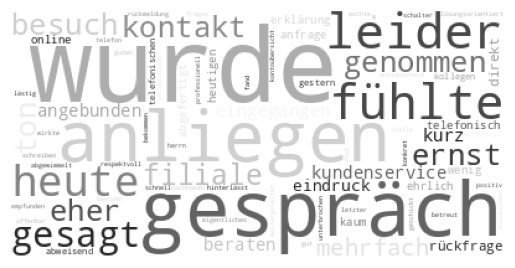

TAN-Verfahren


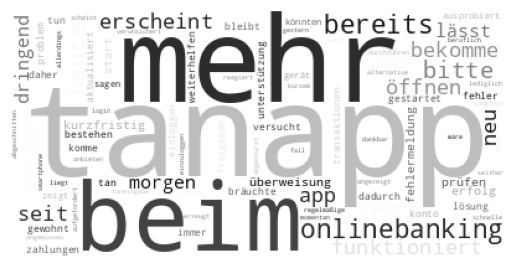

In [ ]:
wordcloud_dic = {}
for index,row in df_group.iterrows():
    wc = WordCloud(background_color='white', colormap = 'binary').generate(row["Kundenanfrage"])
    wordcloud_dic[index] = wc
for k,v in wordcloud_dic.items():
    print(k)
    plt.axis("off")
    plt.imshow(v)
    plt.show()

## LDA

In [ ]:
df_clean["encoded_categories"] = LabelEncoder().fit_transform(df_clean["Unterkategorie2"])
n_topics = [3,6,9,12]
alphas = [0.75,1]
betas = [0.1,0.5]
parameters_RF = {'max_depth':[25],
                 'max_samples':[0.6],
                 'max_features':[9]}
df_score = pd.DataFrame({'alpha':[],'beta':[],'n_topics' :[],'max_depth' : [], 'max_features':[], 'max_samples':[],'accuracy':[]})

for a in alphas:
    for b in betas:
        for n in n_topics:
            lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                                id2word=id2word,
                                                num_topics=n,
                                                random_state=100,
                                                update_every=1,
                                                chunksize=100,
                                                passes=10,
                                                alpha = a,
                                                eta = b,
                                                per_word_topics=False)
            topics = lda_model.print_topics(num_words=10)
            t = lda_model.get_document_topics(corpus,minimum_probability=0)
            columns = []
            for i in range(0,n):
                df[f"topic_{i}"] = [t[d][i][1] for d in range(0,len(t))]
                columns.append(f"topic_{i}")
            X = df[columns]
            y = df['encoded_categories']
            X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=42)

            #Random Forest
            RF = RandomForestClassifier()

            #Hyperparameter Tuning ausführen
            CV_RF = GridSearchCV(RF,
                                parameters_RF,
                                scoring = 'accuracy',
                                cv = 10)

            #Mit dem Trainingsatz trainieren
            CV_RF.fit(X_train,y_train)
            print(CV_RF.best_score_)
            #Feature importances anzeigen
            print(CV_RF.best_estimator_.feature_importances_)
            y_pred_RF = CV_RF.predict(X_test)
            #Accuracy-Wert für den Testsatz speichern
            RF_score = accuracy_score(y_test,y_pred_RF)
            df_score2 = pd.DataFrame({'alpha':[a],'beta':[b], 'n_topics' : [n],
                                    'max_depth' : [CV_RF.best_estimator_.get_params()["max_depth"]],
                                    'max_features':[CV_RF.best_estimator_.get_params()["max_features"]],
                                    'max_samples':[CV_RF.best_estimator_.get_params()["max_samples"]],
                                    'accuracy':[RF_score]})
            df_score = pd.concat([df_score,df_score2],axis = 0)


0.5023684210526316
[0.35896173 0.29848328 0.34255499]
0.5776315789473683
[0.21414205 0.15042196 0.15592336 0.14017532 0.2366159  0.1027214 ]
0.578421052631579
[0.17550003 0.08168788 0.07940101 0.05953491 0.17837196 0.10084644
 0.105302   0.13833018 0.08102558]
0.6528947368421052
[0.13686468 0.06165101 0.06747479 0.04467957 0.16157971 0.05949063
 0.08418377 0.09579383 0.04072011 0.05686419 0.12504814 0.06564957]
0.46263157894736845
[0.42928379 0.26267768 0.30803853]
0.598421052631579
[0.22820069 0.10038802 0.13766378 0.18974683 0.24435904 0.09964164]
0.6189473684210527
[0.16998685 0.08730542 0.08089595 0.06785346 0.20610011 0.07016902
 0.09332773 0.16224406 0.06211739]
0.6644736842105263
[0.17449556 0.09223674 0.05721847 0.0294947  0.07447305 0.10707041
 0.05856371 0.14422907 0.03432997 0.03664981 0.14249681 0.04874169]
0.40710526315789475
[0.36795341 0.31328336 0.31876323]
0.5731578947368421
[0.23846204 0.12622905 0.1603012  0.13579449 0.22714902 0.11206419]
0.643421052631579
[0.169100

In [ ]:
best_result = df_score.loc[df_score['accuracy'].idxmax()]
print("Best Accuracy Run:\n")
print(best_result)

Best Accuracy Run:

   alpha  beta  n_topics  max_depth  max_features  max_samples  accuracy
0   0.75   0.1       3.0       25.0           9.0          0.6      0.48
0   0.75   0.1       6.0       25.0           9.0          0.6      0.54
0   0.75   0.1       9.0       25.0           9.0          0.6      0.72
0   0.75   0.1      12.0       25.0           9.0          0.6      0.72
0   0.75   0.5       3.0       25.0           9.0          0.6      0.40
0   0.75   0.5       6.0       25.0           9.0          0.6      0.58
0   0.75   0.5       9.0       25.0           9.0          0.6      0.68
0   0.75   0.5      12.0       25.0           9.0          0.6      0.62
0   1.00   0.1       3.0       25.0           9.0          0.6      0.44
0   1.00   0.1       6.0       25.0           9.0          0.6      0.60
0   1.00   0.1       9.0       25.0           9.0          0.6      0.66
0   1.00   0.1      12.0       25.0           9.0          0.6      0.80
0   1.00   0.5       3.0       

In [ ]:
# Model LDA with Naive Bayes

df_clean["encoded_categories"] = LabelEncoder().fit_transform(df_clean["Unterkategorie2"])

n_topics = [3, 6, 9, 12]
alphas = [0.75, 1]
betas = [0.1, 0.5]

df_score = pd.DataFrame({'alpha': [], 'beta': [], 'n_topics': [], 'accuracy': []})

for a in alphas:
    for b in betas:
        for n in n_topics:
            lda_model = gensim.models.ldamodel.LdaModel(
                corpus=corpus,
                id2word=id2word,
                num_topics=n,
                random_state=100,
                update_every=1,
                chunksize=100,
                passes=10,
                alpha=a,
                eta=b,
                per_word_topics=False
            )

            t = lda_model.get_document_topics(corpus, minimum_probability=0)
            columns = []
            for i in range(n):
                df[f"topic_{i}"] = [t[d][i][1] for d in range(len(t))]
                columns.append(f"topic_{i}")

            X = df[columns]
            y = df['encoded_categories']

            X_train, X_test, y_train, y_test = train_test_split(
                X, y, test_size=0.2, random_state=42
            )

            # Naive Bayes
            NB = MultinomialNB()
            NB.fit(X_train, y_train)
            y_pred_NB = NB.predict(X_test)
            NB_score = accuracy_score(y_test, y_pred_NB)

            df_score2 = pd.DataFrame({
                'alpha': [a],
                'beta': [b],
                'n_topics': [n],
                'accuracy': [NB_score]
            })

            df_score = pd.concat([df_score, df_score2], axis=0, ignore_index=True)

# Show best result
best_result = df_score.loc[df_score['accuracy'].idxmax()]
print("Best configuration:\n", best_result)

Best configuration:
 alpha       0.75
beta        0.50
n_topics    6.00
accuracy    0.54
Name: 5, dtype: float64


## TF-IDF Vectorization

In [46]:
import numpy as np
import pandas as pd
pd.set_option("display.max_rows", None)
vectorizer = TfidfVectorizer(
    max_features=461,
    ngram_range=(1, 2),  # unigrams + bigrams
    min_df=2,            # ignore rare words (must be in at least 2 documents)
    max_df=0.9           # ignore too common (if term is in more than 90% of documents)
)
X = vectorizer.fit_transform(df_clean["Kundenanfrage"])
y = df_clean["Unterkategorie2"]

# Encode labels
y_encoded = LabelEncoder().fit_transform(y)

# Feature-Namen aus dem Vectorizer
feature_names = vectorizer.get_feature_names_out()

# Funktion: Top-N Wörter pro Kategorie
def top_words_per_category(X, y, feature_names, top_n=10):
    categories = np.unique(y)
    rows = []
    for cat in categories:
        mask = (y == cat)
        # Mittelwert der TF-IDF-Werte pro Wort in dieser Kategorie
        tfidf_means = np.asarray(X[mask].mean(axis=0)).flatten()
        top_idx = tfidf_means.argsort()[::-1][:top_n]
        for i in top_idx:
            rows.append({
                "Kategorie": cat,
                "Wort": feature_names[i],
                "TF-IDF Mittelwert": tfidf_means[i]
            })
    return pd.DataFrame(rows)

# DataFrame mit Top-Wörtern
df_top_words = top_words_per_category(X, y.values, feature_names, top_n=10)

# Optional: Nach Kategorie und Score sortieren
df_top_words = df_top_words.sort_values(["Kategorie", "TF-IDF Mittelwert"], ascending=[True, False])

df_top_words

,Kategorie,Wort,TF-IDF Mittelwert
0,Adressänderung,name,0.206328
1,Adressänderung,adresse,0.154385
2,Adressänderung,neue,0.106045
3,Adressänderung,geändert,0.098771
4,Adressänderung,umgezogen,0.094486
5,Adressänderung,name julia,0.085703
6,Adressänderung,aktualisieren,0.084624
7,Adressänderung,system,0.076341
8,Adressänderung,adresse system,0.071147
9,Adressänderung,julia,0.070219


In [60]:


# Daten
X = df_clean["Kundenanfrage"].astype(str)
y = df_clean["Unterkategorie2"].astype(str)

# Pipeline
pipeline = Pipeline([
    ("tfidf", TfidfVectorizer(
        max_features=1000,
        ngram_range=(1, 2),
        min_df=0.01,
        max_df=0.8
    )),
    ("lr", LogisticRegression(max_iter=2000))
])

# Hyperparameter-Grid (für den Step-Namen "lr" mit Präfix lr__)
param_grid1 = {
    'lr__C': [0.01, 0.1, 1, 10],
    'lr__penalty': ['l1','l2'],
    'lr__solver': ['lbfgs', 'liblinear'],
    'lr__class_weight': [None, 'balanced'],
    'lr__multi_class': ['ovr']
}

param_grid2 = {
    'lr__C': [0.01, 0.1, 1, 10],
    'lr__penalty': ['l1','l2'],
    'lr__solver': ['liblinear'],
    'lr__class_weight': [None, 'balanced'],
    'lr__multi_class': ['ovr']
}

param_grid3 = {
    'lr__C': [0.01, 0.1, 1, 10],
    'lr__penalty': ['l2'],
    'lr__solver': ['lbfgs'],
    'lr__class_weight': [None, 'balanced'],
    'lr__multi_class': ['ovr']
}

param_grid4 = {
    'lr__C': [0.01, 0.1, 1, 10],
    'lr__penalty': ['l2'],
    'lr__solver': ['newton-cg'],
    'lr__class_weight': [None, 'balanced']
}

# LOO-CV
loo = LeaveOneOut()

# GridSearch mit LOO (dauert länger, aber bei n≈250 okay)
grid = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid3,
    cv=loo,
    scoring='f1_macro',
    n_jobs=-1
)
grid.fit(X, y)

best_lr = grid.best_estimator_
print("Best parameters:", grid.best_params_)
print("LOO mean accuracy (CV best_score_):", grid.best_score_)

# (Optional) LOO-Vorhersagen für jeden Punkt – für Report/Metriken pro Klasse
y_pred_loo = cross_val_predict(best_lr, X, y, cv=loo, n_jobs=-1)
print("\nClassification Report (LOO):")
print(classification_report(y, y_pred_loo))

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


Best parameters: {'lr__C': 1, 'lr__class_weight': 'balanced', 'lr__multi_class': 'ovr', 'lr__penalty': 'l2', 'lr__solver': 'lbfgs'}
LOO mean accuracy (CV best_score_): 0.9678714859437751

Classification Report (LOO):
                         precision    recall  f1-score   support

         Adressänderung       0.92      0.96      0.94        24
        Auslandsbuchung       1.00      1.00      1.00        23
      Bearbeitungsdauer       0.91      0.91      0.91        22
               Gebühren       0.89      1.00      0.94        17
          Gerätewechsel       1.00      1.00      1.00        22
              Girokonto       1.00      1.00      1.00        24
            Kreditkarte       1.00      0.96      0.98        27
Nachhaltige Geldanlagen       0.95      0.95      0.95        19
         Namensänderung       0.95      0.95      0.95        20
               Phishing       1.00      0.95      0.97        20
        Servicequalität       1.00      0.94      0.97        16
  

In [61]:
# DataFrame mit echten und vorhergesagten Labels
df_results = pd.DataFrame({
    "Text": X,
    "True Label": y,
    "Predicted Label": y_pred_loo
})

# Nur falsch klassifizierte Zeilen
df_misclassified = df_results[df_results["True Label"] != df_results["Predicted Label"]]

print(f"Falsch klassifiziert: {len(df_misclassified)} von {len(df_results)} Beobachtungen")
df_misclassified

Falsch klassifiziert: 8 von 249 Beobachtungen


,Text,True Label,Predicted Label
74,wüsste gerne sparkassenkreditkarte außereuropä...,Kreditkarte,Gebühren
96,denke darüber geld nachhaltig anzulegen empfeh...,Nachhaltige Geldanlagen,Bearbeitungsdauer
111,vorgang scheint stocken geraten erklären wesha...,Bearbeitungsdauer,Gebühren
128,verständnis betrieb hätte zumindest zwischenme...,Bearbeitungsdauer,Nachhaltige Geldanlagen
148,letzter besuch filiale leider enttäuschend mit...,Servicequalität,Bearbeitungsdauer
169,versehentlich zugangsdaten gefälschten loginse...,Phishing,Adressänderung
224,name laura hofmann wohnortwechsel aktualisiere...,Adressänderung,Namensänderung
230,name bisher anna meier geheiratet trage namen ...,Namensänderung,Adressänderung


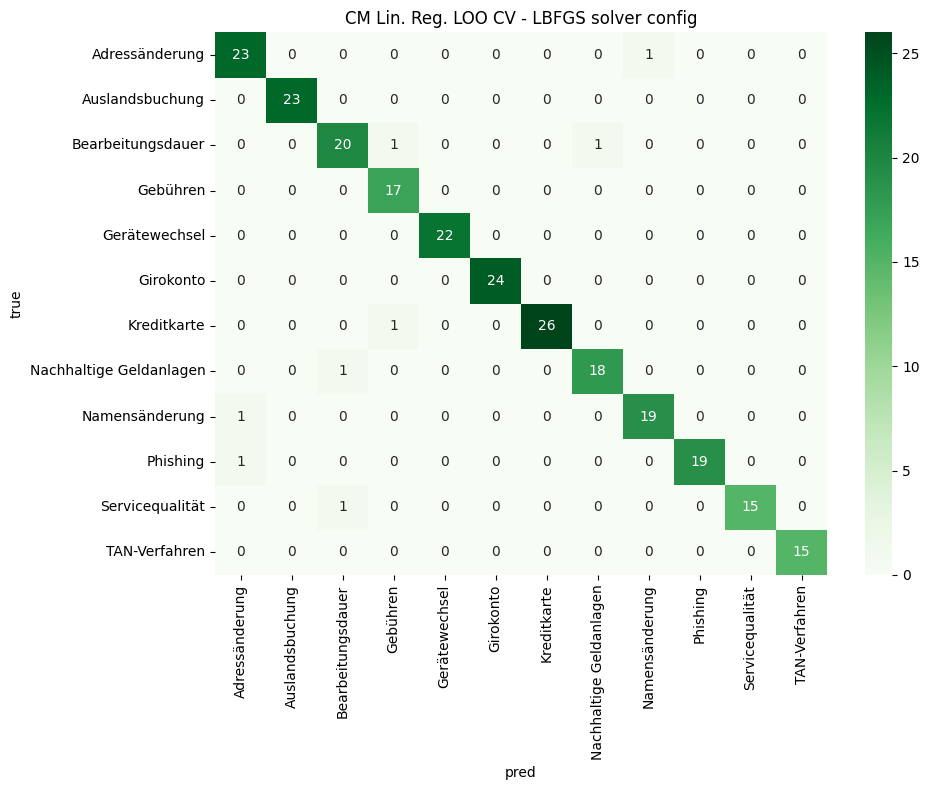

In [67]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Konfusionsmatrix berechnen
labels = sorted(y.unique())  # Original-Labels in fester Reihenfolge
cm = confusion_matrix(y, y_pred_loo, labels=labels)

# Als Heatmap darstellen
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, cmap='Greens',
            xticklabels=labels, yticklabels=labels)
plt.xlabel("pred")
plt.ylabel("true")
plt.title("CM Lin. Reg. LOO CV - LBFGS solver config")
plt.tight_layout()
plt.show()

In [68]:
import pandas as pd
import numpy as np

# Pipeline erneut fitten (falls noch nicht geschehen)
best_lr.fit(X, y)

# Zugriff auf den Vektorizer
vectorizer = best_lr.named_steps["tfidf"]
feature_names = np.array(vectorizer.get_feature_names_out())

# Zugriff auf die Logistic Regression
lr_model = best_lr.named_steps["lr"]

# Für jede Klasse Top-Wörter ausgeben
for class_idx, class_label in enumerate(lr_model.classes_):
    coefs = lr_model.coef_[class_idx]
    top_pos_idx = np.argsort(coefs)[-10:]     # größte positive Koeffizienten
    top_neg_idx = np.argsort(coefs)[:10]      # größte negative Koeffizienten

    print(f"\n=== Klasse: {class_label} ===")
    print("Top positive Wörter:")
    for i in reversed(top_pos_idx):
        print(f"{feature_names[i]:<20} {coefs[i]:.4f}")

    print("\nTop negative Wörter:")
    for i in top_neg_idx:
        print(f"{feature_names[i]:<20} {coefs[i]:.4f}")


=== Klasse: Adressänderung ===
Top positive Wörter:
name                 3.3905
adresse              2.2973
geändert             1.8888
neue                 1.6003
umgezogen            1.5734
aktualisieren        1.3912
anschrift            1.3884
name julia           1.3069
entsprechend         1.2703
adresse system       1.1443

Top negative Wörter:
viele                -0.7132
viele grüße          -0.7132
grüße                -0.7132
wurde                -0.5542
heiße                -0.5468
konto                -0.5112
gibt                 -0.5052
namen                -0.4873
sagen                -0.4449
kreditkarte          -0.4237

=== Klasse: Auslandsbuchung ===
Top positive Wörter:
abbuchung            2.5925
zahlung              2.5597
bestellt             2.2087
transaktion          2.1750
usdollar             1.7793
kronen               1.7587
entdeckt             1.4075
anbieter             1.3830
konto wurde          1.3583
nie                  1.3554

Top negative Wörter:

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


In [ ]:
from sklearn.model_selection import LeaveOneOut
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
import numpy as np

# Textdaten und Labels vorbereiten
texts = df_clean["Kundenanfrage"]
labels = df_clean["Unterkategorie2"]
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(labels)

# TF-IDF-Vektorisierung
vectorizer = TfidfVectorizer(
    max_features=10000,
    ngram_range=(1, 2),
    min_df=2,
    max_df=0.9
)
X = vectorizer.fit_transform(texts)

# Leave-One-Out CV vorbereiten
loo = LeaveOneOut()
y_true = []
y_pred = []

for train_idx, test_idx in loo.split(X):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    model = LogisticRegression(
        C=1,
        penalty='l2',
        solver='liblinear',
        max_iter=1000
    )
    model.fit(X_train, y_train)
    pred = model.predict(X_test)

    y_true.append(y_test[0])
    y_pred.append(pred[0])

# Ergebnis evaluieren
acc = accuracy_score(y_true, y_pred)
print(f"Leave-One-Out Accuracy: {acc:.4f}")

Leave-One-Out Accuracy: 0.8996


In [ ]:
# evaluation ueber gesamten datensatz

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(best_lr, X, y_encoded, cv=skf, scoring='accuracy', n_jobs=-1)
print("Cross-Val Accuracies:", scores)
print("Mean CV-Accuracy:", scores.mean())

Cross-Val Accuracies: [0.96       0.98       0.98       0.96       0.93877551]
Mean CV-Accuracy: 0.9637551020408163


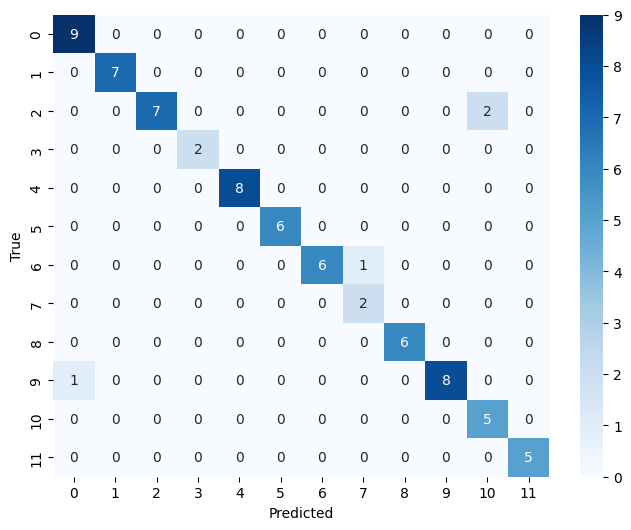

In [ ]:
# confusion matrix fuer testset

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

In [ ]:
# TF-IDF Vectorization with XG Boost
vectorizer = TfidfVectorizer(
    max_features=10000,
    ngram_range=(1, 2),  # unigrams + bigrams
    min_df=2,            # ignore rare words
    max_df=0.9           # ignore too common
)
X = vectorizer.fit_transform(df_clean["Kundenanfrage"])
y = df_clean["Unterkategorie2"]

# Encode labels
y_encoded = LabelEncoder().fit_transform(y)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Hyperparameter grid for XGBoost
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5],
    'learning_rate': [0.1, 0.3],
    'subsample': [0.8, 1],
    'colsample_bytree': [0.8, 1],
    'use_label_encoder': [False],
    'eval_metric': ['mlogloss']  # Avoids warning
}

# Grid search
xgb = XGBClassifier(random_state=42, verbosity=0)
grid = GridSearchCV(xgb, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid.fit(X_train, y_train)

# Best estimator
best_xgb = grid.best_estimator_
print("Best parameters:", grid.best_params_)

# Predict & evaluate
y_pred = best_xgb.predict(X_test)
acc = accuracy_score(y_test, y_pred)

print("Accuracy:", acc)
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Best parameters: {'colsample_bytree': 0.8, 'eval_metric': 'mlogloss', 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.8, 'use_label_encoder': False}
Accuracy: 0.84

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       0.90      0.90      0.90        10
           2       1.00      1.00      1.00         6
           3       0.67      1.00      0.80         2
           4       0.86      0.75      0.80         8
           5       0.80      1.00      0.89         4
           6       1.00      0.67      0.80         3
           7       1.00      0.67      0.80         3
           8       0.67      1.00      0.80         2
           9       1.00      0.80      0.89         5
          10       0.33      0.50      0.40         2
          11       0.67      0.67      0.67         3

    accuracy                           0.84        50
   macro avg       0.82     

In [ ]:
# TF-IDF Vectorization with Support Vector Machiene
vectorizer = TfidfVectorizer(
    max_features=10000,
    ngram_range=(1, 2),  # unigrams + bigrams
    min_df=2,
    max_df=0.9
)
X = vectorizer.fit_transform(df_clean["Kundenanfrage"])
y = df_clean["Unterkategorie2"]

# Encode labels
y_encoded = LabelEncoder().fit_transform(y)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42
)

# Hyperparameter grid for SVM
param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],  # 'linear' is often best for text data
    'class_weight': [None, 'balanced']
}

# Grid search
svc = SVC()
grid = GridSearchCV(svc, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid.fit(X_train, y_train)

# Best estimator
best_svm = grid.best_estimator_
print("Best parameters:", grid.best_params_)

# Predict & evaluate
y_pred = best_svm.predict(X_test)
acc = accuracy_score(y_test, y_pred)

print("Accuracy:", acc)
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Best parameters: {'C': 10, 'class_weight': None, 'kernel': 'linear'}
Accuracy: 0.98

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      1.00      1.00        10
           2       1.00      0.83      0.91         6
           3       0.67      1.00      0.80         2
           4       1.00      1.00      1.00         8
           5       1.00      1.00      1.00         4
           6       1.00      1.00      1.00         3
           7       1.00      1.00      1.00         3
           8       1.00      1.00      1.00         2
           9       1.00      1.00      1.00         5
          10       1.00      1.00      1.00         2
          11       1.00      1.00      1.00         3

    accuracy                           0.98        50
   macro avg       0.97      0.99      0.98        50
weighted avg       0.99      0.98      0.98        50



## BERT

In [ ]:
# 1. Load BERT model
model = SentenceTransformer('all-MiniLM-L6-v2')  # Compact and fast

# 2. BERT embeddings
X = model.encode(df_clean["Kundenanfrage"].tolist(), show_progress_bar=True)

# 3. Encode labels
y = LabelEncoder().fit_transform(df_clean["Unterkategorie2"])

# 4. Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 5. Set parameter grid
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'max_features': ['sqrt', 'log2'],
    'class_weight': [None, 'balanced']
}

# 6. Grid Search with CV
grid = GridSearchCV(
    RandomForestClassifier(random_state=42),
    param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

# 7. Fit model
grid.fit(X_train, y_train)

# 8. Evaluate
print("🔍 Best Parameters:", grid.best_params_)
best_rf = grid.best_estimator_

y_pred = best_rf.predict(X_test)
print("\n✅ Accuracy:", accuracy_score(y_test, y_pred))
print("\n📊 Classification Report:\n", classification_report(y_test, y_pred))

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

Fitting 5 folds for each of 24 candidates, totalling 120 fits
🔍 Best Parameters: {'class_weight': None, 'max_depth': 10, 'max_features': 'log2', 'n_estimators': 200}

✅ Accuracy: 0.7

📊 Classification Report:
               precision    recall  f1-score   support

           0       0.50      1.00      0.67         2
           1       1.00      0.10      0.18        10
           2       0.75      1.00      0.86         6
           3       0.33      0.50      0.40         2
           4       0.89      1.00      0.94         8
           5       0.50      1.00      0.67         4
           6       0.60      1.00      0.75         3
           7       0.67      0.67      0.67         3
           8       1.00      1.00      1.00         2
           9       0.80      0.80      0.80         5
          10       1.00      0.50      0.67         2
          11       1.00      0.33      0.50         3

    accuracy                           0.70        50
   macro avg       0.75      0.7